# Model builder
## Life Cycle Assessment of ``{Operational Energy Moerschberg for 1 year: 1}``
###[CONTEXT]
The model relies on datapackages to ensure replicability of the calculation.


In [1]:
import bw2data as bd
import bw2calc as bc
import bw2io as bi
import bw_processing as bwp
import numpy as np
from pathlib import Path
import pandas as pd
bd.projects.set_current('moeschpond1')
# bd.projects.migrate_project_25() ## This has to be done only once when importing

In [2]:
bd.databases

Databases dictionary with 13 object(s):
	EI 3.8 cutoff image SSP2-Base 2050
	EI 3.8 cutoff image SSP2-RCP19 2050
	EI 3.8 cutoff image SSP2-RCP26 2050
	EI 3.8 cutoff remind SSP2-Base 2050
	EI 3.8 cutoff remind SSP2-PkBudg1150 2050
	EI 3.8 cutoff remind SSP2-PkBudg500 2050
	biosphere3
	ei 3.8 cutoff
	energy_moeschberg
	sib_shan
	solar_huimin
	super_db_2022-10-26
	super_db_2022-10-27

In [3]:
imp = bi.ExcelImporter('./data/inputs/SIB inventory_v2_working.xlsx')
imp.apply_strategies()
imp.match_database("ei 3.8 cutoff", fields=('name','unit','location', 'reference product'))
imp.match_database(fields=('name', 'unit', 'location'))
imp.statistics()
imp.write_excel(only_unlinked=True)

imp.write_database()
imp = bi.ExcelImporter('./data/inputs/lci_solarpv_huimin_masterthesis_combined.xlsx')
imp.apply_strategies()
imp.match_database("ei 3.8 cutoff", fields=('name','unit','location'))
imp.match_database(fields=('name', 'unit', 'location'))
imp.statistics()
imp.write_excel(only_unlinked=True)
imp.write_database()

foreground_importer = bi.ExcelImporter("./data/inputs/lci_moeschberg.xlsx")
foreground_importer.apply_strategies()
foreground_importer.match_database("biosphere3", fields=("name", "unit", "categories"))
foreground_importer.match_database("ei 3.8 cutoff", fields=("name", "unit", "location"))
foreground_importer.statistics()
foreground_importer.write_database()


Extracted 1 worksheets in 0.02 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 7.09 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
14 datasets
140 exchanges
0 unlinked exchanges
  
Wrote matching file to:
/home/jupyter

In [17]:
fu = {bd.get_activity(database="energy_moeschberg", name = "energy demand, operational, Hotel Moeschberg"):1}
fu, objects, remapping_dicts = bd.prepare_lca_inputs(fu, method=('IPCC 2013', 'climate change', 'GWP 100a'))
data_obj_energy = objects[2]
data, _ = data_obj_energy.get_resource("energy_moeschberg_technosphere_matrix.data")
indices, _ = data_obj_energy.get_resource("energy_moeschberg_technosphere_matrix.indices")
flip, _ = data_obj_energy.get_resource("energy_moeschberg_technosphere_matrix.flip")
unique_indices = set([a for b in indices for a in b])

df = pd.DataFrame(columns=['id','name','location','reference product'],index=np.arange(len(unique_indices)))
n=0
for i in unique_indices: 
    df['id'][n]=(i)
    df['name'][n]=(bd.get_activity(i)['name'])
    df['location'][n]=(bd.get_activity(i)['location'])
    df['reference product'][n]=(bd.get_activity(i)['reference product'])
    n += 1
df

,id,name,location,reference product
0,6599,"electricity production, hydro, run-of-river",CH,"electricity, high voltage"
1,8302,"operation, solar collector system, Cu flat pla...",CH,"heat, central or small-scale, other than natur..."
2,10319,"electricity production, wind, 1-3MW turbine, o...",CH,"electricity, high voltage"
3,18352,"electricity production, photovoltaic, 3kWp sla...",CH,"electricity, low voltage"
4,20079,"heat and power co-generation, wood chips, 6667...",CH,"electricity, high voltage"
5,23758,"heat production, wood pellet, at furnace 25kW,...",CH,"heat, central or small-scale, other than natur..."
6,213978,"electricity supply, Hotel Moeschberg, 2021",CH,"electricity, low voltage"
7,213979,"electricity supply, Energie Grosshoechstetten ...",CH,"electricity, low voltage"
8,213980,"electricity, subsidised, 2021",CH,"electricity, low voltage"
9,213981,"heat supply, Hotel Moeschberg, 2021",CH,"heat, Hotel Moeschberg"


In [26]:
id_all = []
sce_names_dict={"id_ei38":"ei 3.8 cutoff",
"id_pre_base":"EI 3.8 cutoff image SSP2-Base 2050",
 "id_pre_19":"EI 3.8 cutoff image SSP2-RCP19 2050",
 "id_pre_26":"EI 3.8 cutoff image SSP2-RCP26 2050",
"id_re_base":"EI 3.8 cutoff remind SSP2-Base 2050",
"id_re_1150":"EI 3.8 cutoff remind SSP2-PkBudg1150 2050",
"id_re_1150":"EI 3.8 cutoff remind SSP2-PkBudg500 2050"
}
for idx, row in df.iterrows():
    act_name = row["name"]
    act_location = row["location"]
    act_ref = row["reference product"]
    row_for_df = {"name":row["name"]}
    
    for name_short, name_long in sce_names_dict.items():
        try:
            act_bg_id = bd.get_activity(database = name_long,name=act_name,location=act_location, product = act_ref).id
        except:
            act_bg_id =row["id"]
        row_for_df[name_short] = act_bg_id

        
    id_all.append(row_for_df)
scenarios_ids=pd.DataFrame(id_all)    
scenarios_ids = scenarios_ids.set_index("id_ei38", drop=False)
scenarios_ids

,name,id_ei38,id_pre_base,id_pre_19,id_pre_26,id_re_base,id_re_1150
id_ei38,,,,,,,
6599,"electricity production, hydro, run-of-river",6599,92881,140945,116913,164977,209765
8302,"operation, solar collector system, Cu flat pla...",8302,89605,137669,113637,161701,206489
10319,"electricity production, wind, 1-3MW turbine, o...",10319,91387,139451,115419,163483,208271
18352,"electricity production, photovoltaic, 3kWp sla...",18352,92843,140907,116875,164939,209727
20079,"heat and power co-generation, wood chips, 6667...",20079,89007,137071,113039,161103,205891
23758,"heat production, wood pellet, at furnace 25kW,...",23758,87162,135226,111194,159258,204046
213978,"electricity supply, Hotel Moeschberg, 2021",213978,213978,213978,213978,213978,213978
213979,"electricity supply, Energie Grosshoechstetten ...",213979,213979,213979,213979,213979,213979
213980,"electricity, subsidised, 2021",213980,213980,213980,213980,213980,213980


In [33]:
aa = {}
def modify_w_arrays(data_object, new_arrays, new_indices_dict):
    n = 1
    for k,v in new_arrays.items():
        n = len(v)        

    data, _ = data_object.get_resource(f"{data_object.metadata['name']}_technosphere_matrix.data")
    indices, _ = data_object.get_resource(f"{data_object.metadata['name']}_technosphere_matrix.indices")
    flip, _ = data_object.get_resource(f"{data_object.metadata['name']}_technosphere_matrix.flip")
    
    
    dp_dict = dict(
        zip(indices.astype("object"),[[tup[0], tup[1]] for tup in zip(data,flip)])
                        )
    # print(dp_dict)
    aa = dp_dict
    for key, value in new_arrays.items():
        dp_dict[key][0] = value
    
    new_foreground = bwp.create_datapackage(
    fs = bwp.generic_zipfile_filesystem(dirpath=Path("./data/inputs"), filename=f"{data_object.metadata['name']}.zip", write=True),
    # combinatorial=True,
    sequential=True,
    )

    for row_col, data_flip in dp_dict.items():
        if not isinstance(data_flip[0], np.ndarray):
            new_array = np.full((n,), fill_value = data_flip[0])
            dp_dict[row_col][0] = new_array
            
    new_data = np.array([val[0] for val in dp_dict.items()])
    
    new_indices=[]
    for row, col in indices:
        new_indices.append((new_indices_dict[row], col))
               
        
    new_foreground.add_persistent_array(
    matrix="technosphere_matrix",
    data_array=new_data,
    indices_array=np.array(new_indices, dtype=bwp.INDICES_DTYPE),  
    flip_array=flip,
    name=data_object.metadata['name'],
)

    # return dp_dict
    return new_foreground

{213982: 1}

In [58]:
def matrix_raw(object_dp):
    data, _ = object_dp.get_resource("energy_moeschberg_technosphere_matrix.data")
    indices, _ = object_dp.get_resource("energy_moeschberg_technosphere_matrix.indices")
    flip, _ = object_dp.get_resource("energy_moeschberg_technosphere_matrix.flip")
    unique_indices = set([a for b in indices for a in b])
    mapping_act=dict.fromkeys(int(i) for i in unique_indices) #json accepts only int not int32
    for i in unique_indices:
        mapping_act[i]=bd.get_activity(i)['name']
    rows = [tup[0] for tup in indices]
    cols = [tup[1] for tup in indices]

    import pandas as pd
    matrix_raw = pd.DataFrame({"row":rows, 
                               "col":cols, 
                               "from":[mapping_act[idx] for idx in rows], 
                               "to":[mapping_act[idx] for idx in cols],
                               "data":data
                              })
    matrix = matrix_raw.pivot(index='row',columns='col', values='data').fillna(0)
    return matrix_raw
matrix_raw(objects[2])

,row,col,from,to,data
0,6599,213979,"electricity production, hydro, run-of-river","electricity supply, Energie Grosshoechstetten ...",0.907000
1,6599,213980,"electricity production, hydro, run-of-river","electricity, subsidised, 2021",0.320000
2,8302,213981,"operation, solar collector system, Cu flat pla...","heat supply, Hotel Moeschberg, 2021",0.004668
3,10319,213980,"electricity production, wind, 1-3MW turbine, o...","electricity, subsidised, 2021",0.020000
4,18352,213978,"electricity production, photovoltaic, 3kWp sla...","electricity supply, Hotel Moeschberg, 2021",0.440600
5,18352,213979,"electricity production, photovoltaic, 3kWp sla...","electricity supply, Energie Grosshoechstetten ...",0.026000
6,18352,213980,"electricity production, photovoltaic, 3kWp sla...","electricity, subsidised, 2021",0.460000
7,20079,213980,"heat and power co-generation, wood chips, 6667...","electricity, subsidised, 2021",0.200000
8,23758,213981,"heat production, wood pellet, at furnace 25kW,...","heat supply, Hotel Moeschberg, 2021",0.995300
9,213978,213978,"electricity supply, Hotel Moeschberg, 2021","electricity supply, Hotel Moeschberg, 2021",1.000000


In [45]:
# from utils import modify_w_arrays

fu = {bd.get_activity(database="energy_moeschberg", name = "energy demand, operational, Hotel Moeschberg"):1}
fu, objects, remapping_dicts = bd.prepare_lca_inputs(fu, method=('IPCC 2013', 'climate change', 'GWP 100a'))

matrices_raw =
results = []
scenarios_fg = 2
for col in scenarios_ids.iteritems():
    scenario_name = col[0]
    if "name" not in scenario_name: 
        print("##############")
        print("SCENARIO CALCULATION: ", scenario_name)
        print("##############")
        new_ind_dict= {}
        for idx, row in scenarios_ids.iterrows():
            original_id = idx
            new_id = row[scenario_name]
            new_ind_dict[original_id]=new_id
            
            new_arrays = {
                        (213981, 213982): [655489,655489*.9,655489*.9,655489*.9], #PV becomes the unique elec source
                        (213978, 213982): [32179,32179*1.1,32179*1.1,32179*1.1],
            }
        new_foreground = modify_w_arrays(objects[2], new_arrays, new_ind_dict)
        db=bd.Database(sce_names_dict[scenario_name])
        db_dp = db.datapackage()
        
        
        lca_b = bc.LCA(
        demand=fu,
        data_objs=objects + [db_dp] + [new_foreground],
        use_distributions=False,
        use_arrays=True,
        )
        lca_b.lci()
        lca_b.lcia()
        lca_b.keep_first_iteration()
        iterations = scenarios_fg
        
        counter= 0
        for idx, _ in zip(range(iterations), lca_b):
            scenario_results = {}
            scenario_results["bg"]=scenario_name
            scenario_results["sc_number"]=counter
            scenario_results["score"]=lca_b.score               
            results.append(scenario_results)
            counter+=1
        
        scores_b = [lca_b.score for _ in zip(range(iterations), lca_b)]
        print("RESULTS", scores_b)
results_df = pd.DataFrame(results)
results_df

/tmp/ipykernel_773295/2203948364.py:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col in scenarios_ids.iteritems():


##############
SCENARIO CALCULATION:  id_ei38
##############
{(6599, 213979): [0.907, True], (6599, 213980): [0.32, True], (8302, 213981): [0.004668, True], (10319, 213980): [0.02, True], (18352, 213978): [0.4406, True], (18352, 213979): [0.026, True], (18352, 213980): [0.46, True], (20079, 213980): [0.2, True], (23758, 213981): [0.9953, True], (213978, 213978): [1.0, False], (213978, 213982): [32179.0, True], (213979, 213978): [0.5594, True], (213979, 213979): [1.0, False], (213980, 213979): [0.067, True], (213980, 213980): [1.0, False], (213981, 213981): [1.0, False], (213981, 213982): [655489.0, True], (213982, 213982): [1.0, False]}
RESULTS [0.027697127549851555, 0.33116044116494214]
##############
SCENARIO CALCULATION:  id_pre_base
##############
{(6599, 213979): [0.907, True], (6599, 213980): [0.32, True], (8302, 213981): [0.004668, True], (10319, 213980): [0.02, True], (18352, 213978): [0.4406, True], (18352, 213979): [0.026, True], (18352, 213980): [0.46, True], (20079, 213980)

,bg,sc_number,score
0,id_ei38,0,0.027697
1,id_ei38,1,0.331160
2,id_pre_base,0,0.032134
3,id_pre_base,1,0.370111
4,id_pre_19,0,0.023746
5,id_pre_19,1,0.273057
6,id_pre_26,0,0.025371
7,id_pre_26,1,0.291402
8,id_re_base,0,0.014812
9,id_re_base,1,0.179576


<AxesSubplot: xlabel='score', ylabel='bg'>

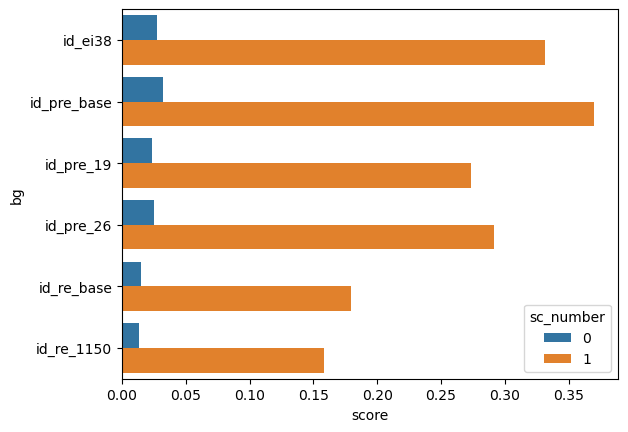

In [51]:
import seaborn as sns
# hue="time",
sns.barplot(data=results_df, x="score", y="bg", hue = "sc_number")